# Introduction

This notebook transforms Cherenkov-excited luminescence structured light images (CELSI) into an autostereogram. 

CELSI is an imaging modality that uses light generated by radiation to excite phosphorescent compounds. In this case, the phosphorescent compounds are injected into two tumors. From left to right, the three-panel image used for the autostereogram show a simulated depth map generated from a room-light image, the Cherenkov emission from the radiation beam which is scanned over the mouse, and the lifetime decay estimates calculated from the phosphorescent emission in the tumors. 

Random-dot autostereograms were made popular in the 90s through the MagicEye book series. Using this method, a small tile of random dots can be patterned across a larger gray-scale depth-map image. The intensity of each pixel is used to shift the small random-dot tiles in such a way that when they are viewed with the proper convergence parts of the tiles appear to float above the image.

During CELSI data collection, the raw images often look like pure noise, but through image processing techniques to reduce background noise a signal can be detected. Similarly, at first glance random-dot autostereograms also appear completely random. It is not until the observer focuses beyond the image that the scene appears to pop out. 


In [2]:
import os
import numpy
import PIL
from PIL import ImageFont
from PIL import ImageDraw 
import skimage
from skimage import io
from skimage.filters import gaussian, rank, threshold_otsu
#from skimage.segmentation import clear_border
from skimage.morphology import square, disk
from skimage.transform import rescale
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from IPython.display import Image
%matplotlib inline
import autostereogram as autos
# Ignore warnings so they won't be displayed
import warnings
warnings.filterwarnings('ignore')

In [3]:
input_dir = 'PtG4_Mouse_13/'

# Read Room-light image
* Two mice were imaged simultaneously, so the image must be cropped around the mouse of interest

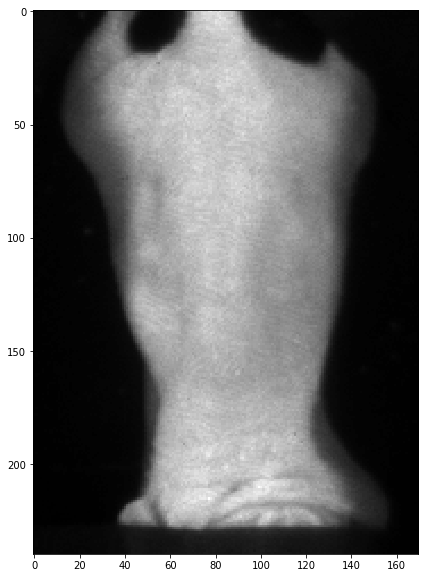

In [4]:
file_name = 'MED_Rm.png'
#file_name = 'Rm_imDepth.png'
room_file = os.path.join(input_dir, file_name)
rm_im = skimage.io.imread(room_file)
# right mouse
cropped_rm_im = rm_im[100:340,285:455]
# Show image
fig = plt.figure(figsize=(15,10))
plt.imshow(cropped_rm_im, cmap='gray')
plt.show()
# Save image
skimage.io.imsave(os.path.join(input_dir,'Cropped_Rm_im.tif'),
                  cropped_rm_im.astype(numpy.uint16))

## Use modified depth-map
 While the room light image provides some sense of depth, something more closely resembling a depth-map was created from this image using GIMP. In this depth-map the lighter values indicate areas closer to the camers, and darker values are further away.

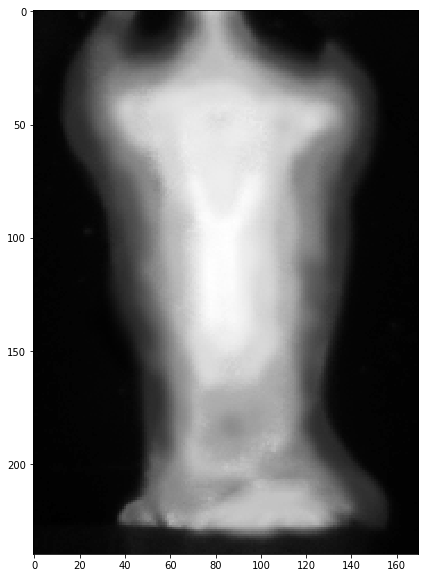

In [5]:
file_name_depth = 'Rm_im_Depth.png'
room_file_depth = os.path.join(input_dir, file_name_depth)
rm_im_depth = skimage.io.imread(room_file_depth)
# right mouse
# Show image
fig = plt.figure(figsize=(15,10))
plt.imshow(rm_im_depth, cmap='gray')
plt.show()

In [6]:
cropped_rm_im = rm_im_depth.copy()

## Enhance image
* Gaussian blur
* Find binary mask
* Contrats adjustment
* Apply mask
* Reduce bitdepth
* Convert data-type to float [0,1]

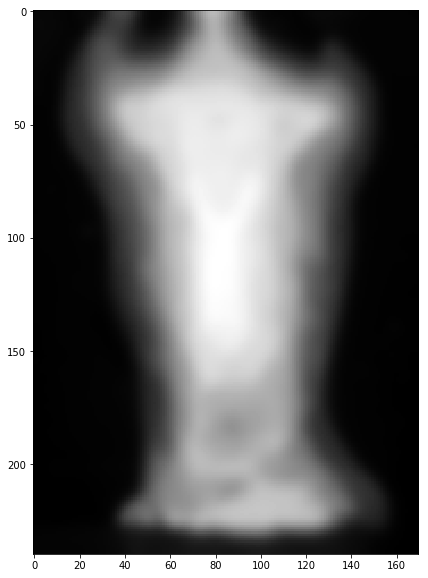

In [7]:
# Smooth image
smooth_rm_im = gaussian(cropped_rm_im, sigma=2.5)
# Show image
fig = plt.figure(figsize=(15,10))
plt.imshow(smooth_rm_im, cmap='gray')
plt.show()

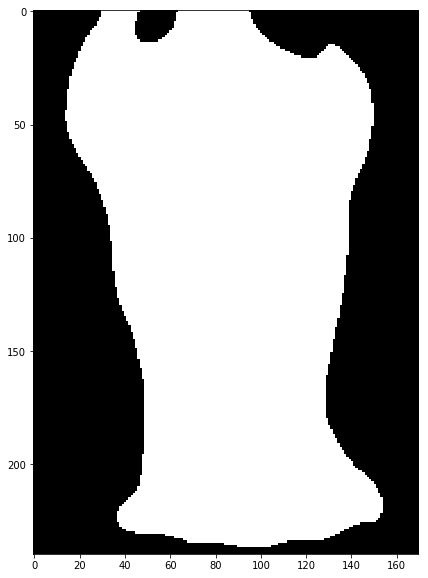

In [8]:
im_thresh = .3*threshold_otsu(smooth_rm_im)
mask_im = smooth_rm_im>im_thresh
# Show mask
fig = plt.figure(figsize=(15,10))
plt.imshow(mask_im, cmap='gray')
plt.show()

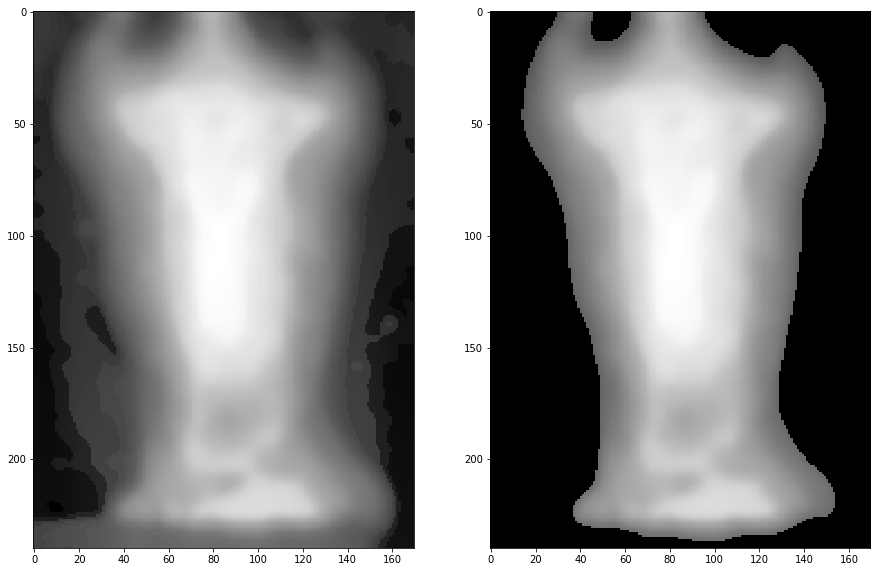

In [9]:
disk_elem = disk(150)
eq_rm_im = rank.equalize(smooth_rm_im, selem=disk_elem)
eq_mask_rm_im = mask_im*eq_rm_im
# Show image
fig = plt.subplots(1,2,figsize=(15,10))
ax1 = plt.subplot2grid((1,2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
ax1.imshow(eq_rm_im, cmap='gray')
ax2.imshow(eq_mask_rm_im, cmap='gray')
plt.show()

# Read Cherenkov image
During radiation therapy an external radiation source can be shaped to provide a method to target and kill cancer cells. Above a certain threshold, the highly-energize electrons passing through tissue will generate optical light that is predominantly blue. This blue light is then used to excite phosphorescent compounds in the tumor.

* Read image
* Find maximum intensity projection
* Apply over room image

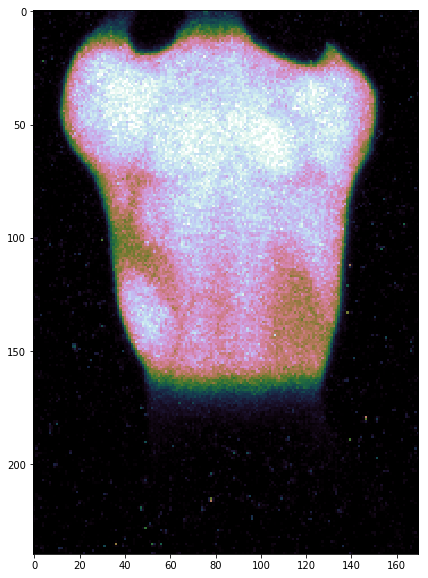

In [10]:
ch_name = 'Cherenkov.tif'
ch_file = os.path.join(input_dir, ch_name)
ch_im = skimage.io.imread(ch_file)
ch_mip_im = numpy.nanmax(ch_im, axis=0)
lower_lim = numpy.nanpercentile(ch_mip_im,33)
upper_lim = numpy.nanpercentile(ch_mip_im, 99.5)
# Show image
fig = plt.figure(figsize=(15,10))
plt.imshow(ch_mip_im, cmap='cubehelix', vmin=lower_lim, vmax=upper_lim)
plt.show()
# Save image
skimage.io.imsave(os.path.join(input_dir,'Cherenkov_MIP.tif'),
                  ch_mip_im.astype(numpy.uint16))

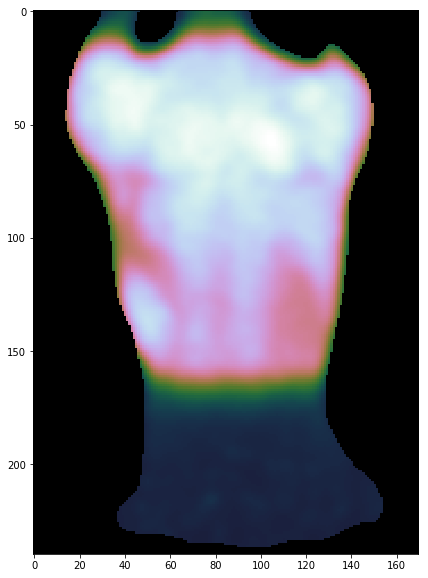

In [11]:
smooth_ch_mip_im = gaussian(ch_mip_im, sigma=2.5)
smooth_mask_ch_mip_im = smooth_ch_mip_im*mask_im
# Show image
fig = plt.figure(figsize=(15,10))
plt.imshow(smooth_mask_ch_mip_im, cmap='cubehelix')
plt.show()

# Read tau image
The tau image provides a pixel-wise estimate for the decay time of the phosphorescent compound. These compounds are sensitive to oxygen, so when they are deprived of oxygen, as in many tumor models, the intensity will be higher and last longer. Changes in tau can be converted to pO2 if the temperature and quenching constants are known.

* Read image

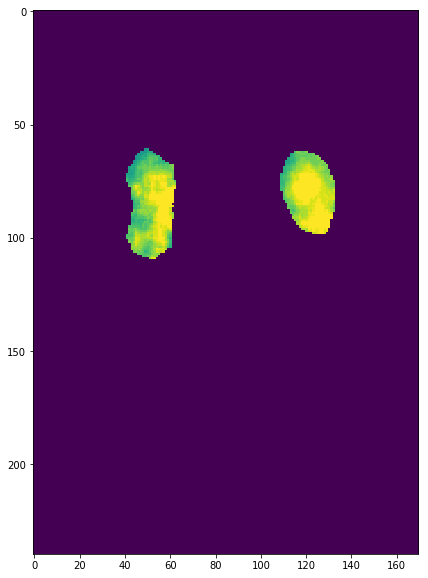

In [12]:
tau_name = 'Tau.tif'
tau_file = os.path.join(input_dir, tau_name)
tau_im = skimage.io.imread(tau_file)
lower_lim = numpy.nanmin(tau_im)
upper_lim = numpy.nanmax(tau_im)
# Show image
fig = plt.figure(figsize=(15,10))
plt.imshow(tau_im, cmap='viridis', vmin=lower_lim, vmax=upper_lim)
plt.show()

# Combine 3 images
* Room light
* Room light + Cherenkov
* Room light + Tau(pO2)

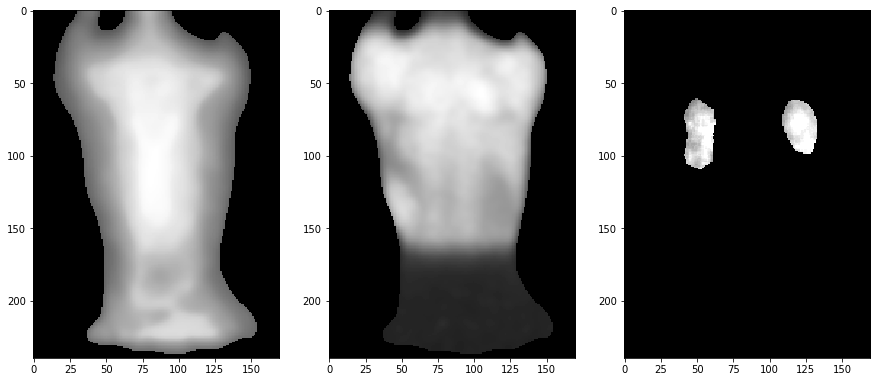

In [13]:
# Convert room image to float on range [0,1]
eq_mask_rm_im_01 = eq_mask_rm_im - numpy.nanmin(eq_mask_rm_im)
eq_mask_rm_im_01 = eq_mask_rm_im_01.astype(float)/numpy.nanmax(eq_mask_rm_im_01)
# Convert Cherenkov image to float on range [0,1]
ch_mip_im_01 = smooth_mask_ch_mip_im - numpy.nanmin(smooth_mask_ch_mip_im)
ch_mip_im_01 = ch_mip_im_01.astype(float)/numpy.nanmax(ch_mip_im_01)
# Convert Tau image to float on range [0,1]
tau_im_01 = tau_im - numpy.nanmin(tau_im)
tau_im_01 = tau_im_01.astype(float)/numpy.nanmax(tau_im_01)

fig = plt.subplots(1,3,figsize=(15,10))
ax1 = plt.subplot2grid((1,3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1))
ax3 = plt.subplot2grid((1, 3), (0, 2))
ax1.imshow(eq_mask_rm_im_01, cmap='gray')
ax2.imshow(ch_mip_im_01, cmap='gray')
ax3.imshow(tau_im_01, cmap='gray')
plt.show()

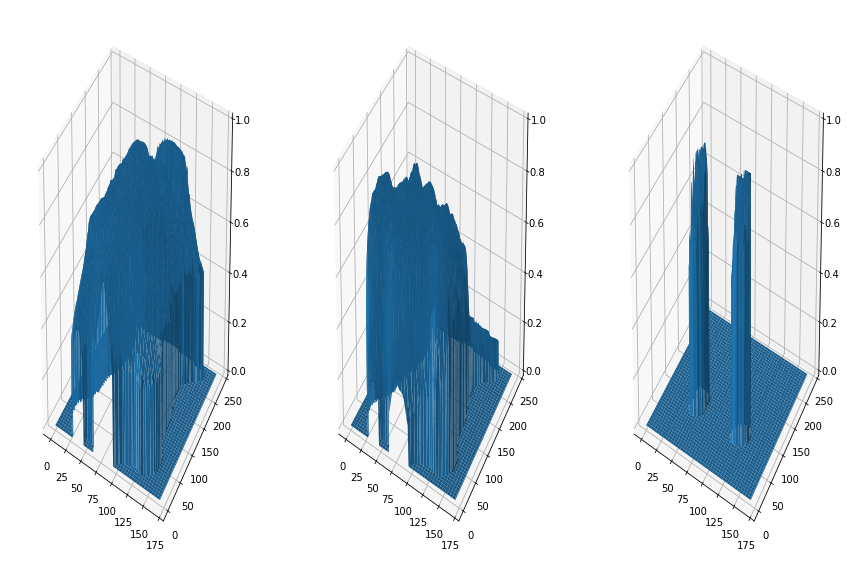

In [14]:
im_shape = numpy.shape(eq_mask_rm_im_01)
ny = im_shape[0]
nx = im_shape[1]
y = range(ny)
x = range(nx)
X, Y = numpy.meshgrid(x, y)
fig = plt.subplots(1,3,figsize=(15,10))
ax1 = plt.subplot2grid((1,3), (0, 0), projection='3d')
ax2 = plt.subplot2grid((1, 3), (0, 1), projection='3d')
ax3 = plt.subplot2grid((1, 3), (0, 2), projection='3d')
ax1.plot_surface(X,Y,eq_mask_rm_im_01)
ax2.plot_surface(X,Y,ch_mip_im_01)
ax3.plot_surface(X,Y,tau_im_01)
plt.show()

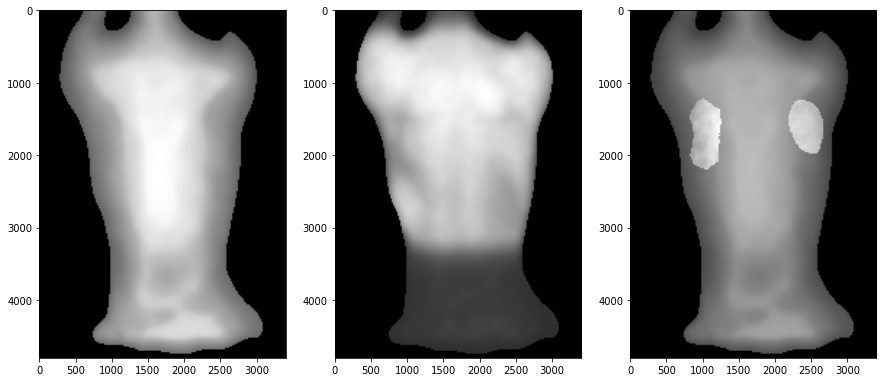

In [15]:
only_rm_im = 255*(eq_mask_rm_im_01)
rm_and_ch_im = 255*(eq_mask_rm_im_01/7 + ch_mip_im_01/1.1667)
rm_tau_im = 255*(eq_mask_rm_im_01/1.5+ tau_im_01/3)

only_rm_im_big = rescale(only_rm_im, 20)
rm_and_ch_im_big  = rescale(rm_and_ch_im, 20)
rm_tau_im_big  = rescale(rm_tau_im, 20)

im_shape = numpy.shape(only_rm_im_big)
ny = im_shape[0]
nx = im_shape[1]
y = range(ny)
x = range(nx)
X, Y = numpy.meshgrid(x, y)

fig = plt.subplots(1,3,figsize=(15,10))
ax1 = plt.subplot2grid((1,3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1))
ax3 = plt.subplot2grid((1, 3), (0, 2))
ax1.imshow(only_rm_im_big, cmap='gray')
ax2.imshow(rm_and_ch_im_big, cmap='gray')
ax3.imshow(rm_tau_im_big, cmap='gray')
plt.show()

#fig = plt.subplots(1,3,figsize=(15,10))
#ax1 = plt.subplot2grid((1,3), (0, 0), projection='3d')
#ax2 = plt.subplot2grid((1, 3), (0, 1), projection='3d')
#ax3 = plt.subplot2grid((1, 3), (0, 2), projection='3d')
#ax1.plot_surface(X,Y,only_rm_im_big)
#ax2.plot_surface(X,Y,rm_and_ch_im_big)
#ax3.plot_surface(X,Y,rm_tau_im_big)
#plt.show()

In [16]:
padding = 250
im_holder = numpy.zeros([ny+2*padding, 3*nx+4*padding,])

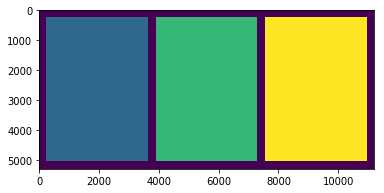

In [17]:
im_holder[padding:ny+padding,padding:nx+padding] = 1
im_holder[padding:ny+padding,nx+2*padding:2*nx+2*padding]=2
im_holder[padding:ny+padding,2*nx+3*padding:3*nx+3*padding]=3
plt.imshow(im_holder)
plt.show()

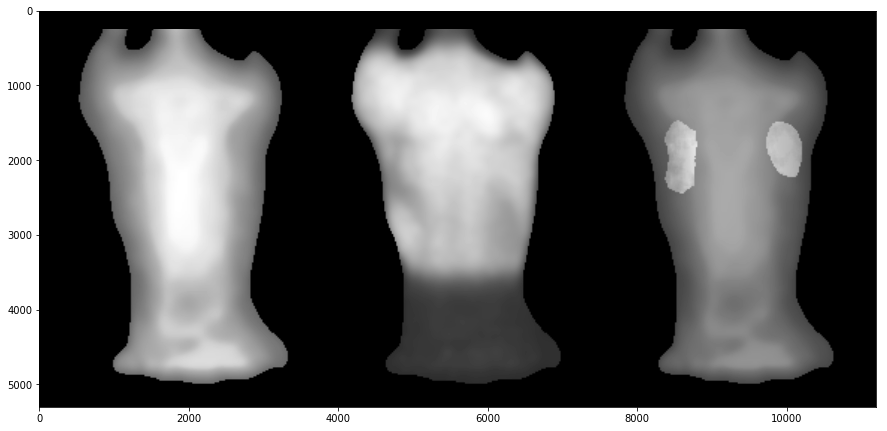

In [18]:
im_holder[padding:ny+padding,padding:nx+padding] = only_rm_im_big
im_holder[padding:ny+padding,nx+2*padding:2*nx+2*padding] = rm_and_ch_im_big
im_holder[padding:ny+padding,2*nx+3*padding:3*nx+3*padding] = rm_tau_im_big
fig = plt.figure(figsize=(15,10))
plt.imshow(im_holder, cmap='gray')
plt.show()


# Create autostereogram

In [19]:
cur_tile = autos.createRandomTile([300,300])

# Instead of random-dots, a small image can be tiled
#tile_file = os.path.join(input_dir, 'ThayerShield_Green.jpg')
#cur_tile = skimage.io.imread(tile_file)
#cur_tile_sm = rescale(cur_tile,1,preserve_range=True).astype(numpy.uint8)
#cur_tile = PIL.Image.fromarray(cur_tile_sm)


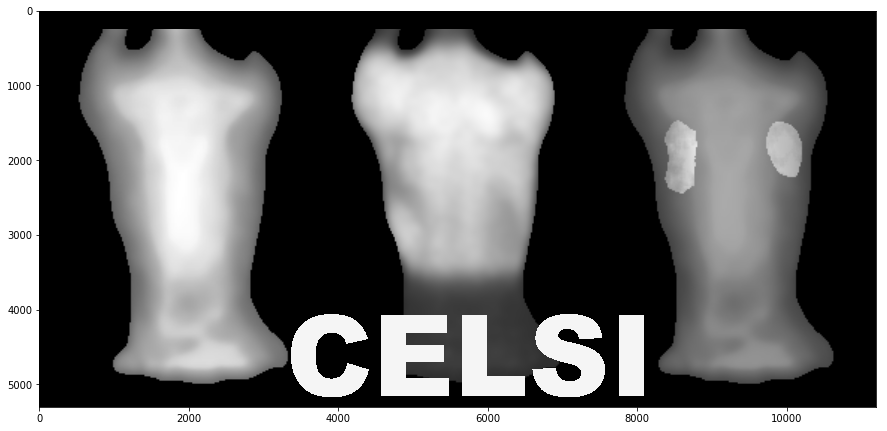

In [20]:
depth_im = PIL.Image.fromarray(im_holder)
draw = ImageDraw.Draw(depth_im)
font = ImageFont.truetype("Arial Black.ttf", 1500)
# draw.text((x, y),"Sample Text",(r,g,b))
draw.text((3300, 3500),"CELSI",(245),font=font)
fig = plt.figure(figsize=(15,10))
plt.imshow(depth_im, cmap='gray')
plt.show()

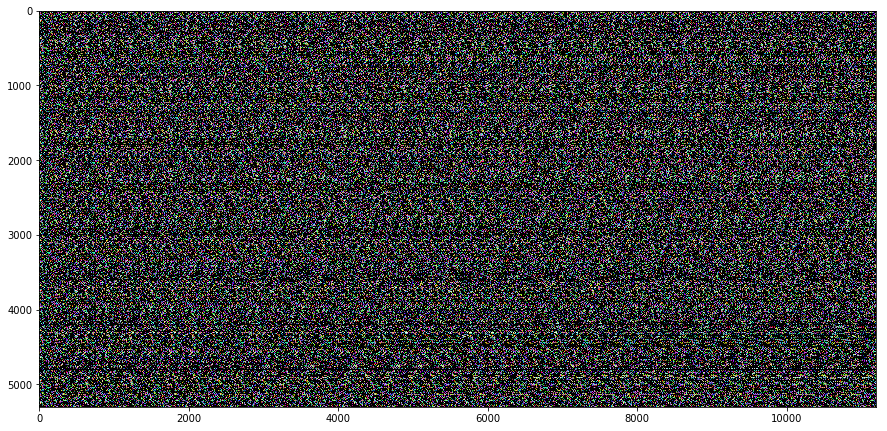

In [21]:
im_3d = autos.createAutostereogram(depth_im, cur_tile)
fig = plt.figure(figsize=(15,10))
plt.imshow(im_3d)
plt.show()
skimage.io.imsave('AutoStereogram_PtG4.png',im_3d)